In [ ]:
import cv2
import matplotlib.pyplot as plt
import os, shutil
from google.colab import drive
from google.colab.patches import cv2_imshow
import tensorflow as tf
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


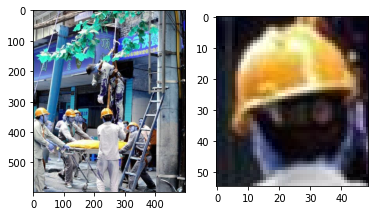

In [ ]:
img=cv2.imread("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/001446_jpg.rf.00a11ab7cffb0a8fec57e98b2c4663d5.jpg")
crop_img = img[318:373, 216:265]
fig,axs=plt.subplots(1,2)
axs[0].imshow(img)
axs[1].imshow(crop_img)

In [ ]:
if os.path.isdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/yes_helmet"):
    shutil.rmtree("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/yes_helmet")
os.mkdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/yes_helmet")

if os.path.isdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/no_helmet"):
    shutil.rmtree("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/no_helmet")
os.mkdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/no_helmet")

count = 0
count_head_yes_helmet=1
count_head_no_helmet=1
print("\nUsing for loop")
with open("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/_annotations.txt") as fp:
    for line in fp:
        count += 1
        data=line.strip().split()
        file_name=data[0]
        img=cv2.imread("/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/"+file_name)
        for head in data[1:]:
            head_details=head.split(",")
            head_details=[int(i) for i in head_details]
            start_point = (head_details[0],head_details[1])
            end_point = (head_details[2],head_details[3])
            cropped_image=img[start_point[1]:end_point[1],start_point[0]:end_point[0]]
            dim=(76,76)
            resized = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
            has_helmet=head_details[4]
            if has_helmet:
                head_filename="/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/yes_helmet/"+str(count_head_yes_helmet)+".jpg"
                count_head_yes_helmet+=1
            else:
                head_filename="/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/no_helmet/"+str(count_head_no_helmet)+".jpg"
                count_head_no_helmet+=1
            cv2.imwrite(head_filename,resized)
        if count%500==0:
            print("Image file nmbr",count)
print("Number of helmet - heads = ",count_head_yes_helmet)
print("Number of no helmet - heads = ",count_head_no_helmet)



Using for loop
Image file nmbr 500
Image file nmbr 1000
Image file nmbr 1500
Image file nmbr 2000
Image file nmbr 2500
Image file nmbr 3000
Image file nmbr 3500
Image file nmbr 4000
Image file nmbr 4500
Image file nmbr 5000
Number of helmet - heads =  15358
Number of no helmet - heads =  4875


In [ ]:
def load_data(path): #loads data from cropped images so they could be inputted into model
    x_train = []
    y_train = []
    yes_helmet_location=os.path.join(location,"yes_helmet")
    no_helmet_location=os.path.join(location,"no_helmet")
    yes_helmet_files=os.listdir(yes_helmet_location)
    no_helmet_files=os.listdir(no_helmet_location)
    
    for ffile in yes_helmet_files[:5000]: 
        img=cv2.imread(os.path.join(yes_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(1)
    for ffile in no_helmet_files:
        img=cv2.imread(os.path.join(no_helmet_location,ffile))
        tr_x = image.img_to_array(img)
        tr_x = preprocess_input(tr_x)
        x_train.append(img)
        y_train.append(0)
    return np.array(x_train), to_categorical(y_train)

location="/content/drive/My Drive/HardhatCourse/HHDYoloV2/train/"
x_train, y_train = load_data(location)

print(type(y_train))
print(y_train.shape)    # 808,4
print(x_train.shape)    # 808,299,299,3

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet',  
                               input_shape=(76, 76, 3), pooling='avg')
for l in base_model.layers:
    l.trainable = False

input = Input(shape=(76, 76, 3))
t = base_model(input)
o = Dense(2, activation='sigmoid')(t) #sigmoid standard for two class image classification (yes hard hat vs no hard hat)
model = Model(inputs=input, outputs=o)


    
loss = tf.keras.losses.CategoricalCrossentropy()
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

model.summary()



batch_size = 48

n_epochs=50

# Callbacks
es_callback = EarlyStopping(monitor='val_loss', patience=25) #Stop training after val_loss stops moving for 25 epochs
lr_callback = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto'
) #Optimises training time and effort if val_loss plateaus

history = model.fit(
    x_train,y_train, validation_data=(x_test,y_test), 
    batch_size=batch_size,
    epochs=n_epochs, callbacks=[es_callback, lr_callback]
)

model.save("models/just_vgg16.h5")

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 76, 76, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14,715,714
Trainable params: 1,026
Non-trainable params: 14,714,688
_________________________________________________________________


NameError: ignored

Testing

In [ ]:
if os.path.isdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/yes_helmet"):
    shutil.rmtree("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/yes_helmet")
os.mkdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/yes_helmet")

if os.path.isdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/no_helmet"):
    shutil.rmtree("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/no_helmet")
os.mkdir("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/no_helmet")

count = 0
count_head_yes_helmet=1
count_head_no_helmet=1
print("\nUsing for loop")
with open("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/_annotations.txt") as fp:
    for line in fp:
        count += 1
        data=line.strip().split()
        file_name=data[0]
        img=cv2.imread("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/"+file_name)
        for head in data[1:]:
            head_details=head.split(",")
            head_details=[int(i) for i in head_details]
            start_point = (head_details[0],head_details[1])
            end_point = (head_details[2],head_details[3])
            cropped_image=img[start_point[1]:end_point[1],start_point[0]:end_point[0]]
            dim=(76,76)
            resized = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
            has_helmet=head_details[4]
            if has_helmet:
                head_filename="/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/yes_helmet/"+str(count_head_yes_helmet)+".jpg"
                count_head_yes_helmet+=1
            else:
                head_filename="/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/no_helmet/"+str(count_head_no_helmet)+".jpg"
                count_head_no_helmet+=1
            cv2.imwrite(head_filename,resized)
        if count%500==0:
            print("Image file nmbr",count)
print("Number of helmet - heads = ",count_head_yes_helmet)
print("Number of no helmet - heads = ",count_head_no_helmet)


In [ ]:
model=load_model("models/just_vgg16.h5")
x_tester, y_tester = load_data("/content/drive/My Drive/HardhatCourse/HHDYoloV2/test/")
model.evaluate(x_tester,y_tester)

NameError: ignored

Converting to TFlite to deploy to edge

In [ ]:
model=load_model("/content/drive/My Drive/hardhatclassifierdiff.h5")

In [ ]:
model.save(
    filepath="/content/drive/My Drive/HardHatMODEL/finishedmodel",
    overwrite=True,
    include_optimizer=True,
    save_format=False
)

INFO:tensorflow:Assets written to: /content/drive/My Drive/HardHatMODEL/finishedmodel-tobelite/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/HardHatMODEL/finishedmodel-tobelite/assets


In [ ]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/


In [ ]:
#Save the keras model after compiling
model.save("/content/drive/My Drive/hardhatclassifierdiff.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprczxirrz/assets


In [ ]:
with open("/content/drive/My Drive/HardHatTFLITE/hardhatmagic.tflite", "wb") as f:
  f.write(tflite_model)

Testing TFLite model

In [ ]:
import tflite_runtime.interpreter as tflite
import tflite
import tflite_runtime

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/HardHatTFLITE/hardhatmagic.tflite")
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_test2 = cv2.imread("/content/drive/My Drive/MrScott.jpg")
input_shape = input_details[0]['shape']
input_test = cv2.imread("/content/drive/My Drive/hardhatyes.jfif")

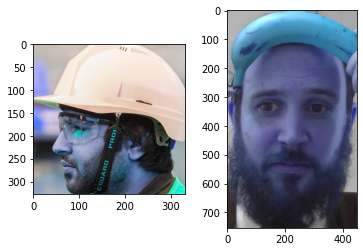

In [ ]:
fig,axs=plt.subplots(1,2)
axs[0].imshow(input_test)
axs[1].imshow(input_test2)

Testing

In [ ]:
input_test.shape

(76, 76, 3)

In [ ]:
input_test = cv2.resize(input_test, (76,76), interpolation = cv2.INTER_AREA)

In [ ]:
input_test.shape

(76, 76, 3)

In [ ]:
input_test = input_test.astype("float32")

In [ ]:
input_test = np.expand_dims(input_test, axis=0)

In [ ]:
input_test.shape

(1, 76, 76, 3)

In [ ]:
#Set the value of Input tensor
interpreter.set_tensor(input_details[0]['index'], input_test)
interpreter.invoke()

In [ ]:
#prediction for input data
output_data = interpreter.get_tensor(output_details[0]['index'])
pred = output_data[0][1] * 100 #prediction probability

In [ ]:
print(pred)

100.0


In [ ]:
input_test2.shape

(177, 174, 3)

In [ ]:
input_test2 = input_test2.astype("float32")

In [ ]:
input_test2 = np.expand_dims(input_test2, axis=0)

In [ ]:
input_test2.shape

(1, 76, 76, 3)

In [ ]:
#Set the value of Input tensor
interpreter.set_tensor(input_details[0]['index'], input_test2)
interpreter.invoke()

In [ ]:
#prediction for input data
output_data = interpreter.get_tensor(output_details[0]['index'])
pred = output_data[0][1] * 100 #prediction probability

In [ ]:
print(pred)

100.0
